In [1]:
%matplotlib inline

In [34]:
import geopandas as gpd
from dem_stitcher.geojson_io import read_geojson_gzip
import pandas as pd
from distmetrics import compute_mahalonobis_dist_2d
import matplotlib.pyplot as plt
import warnings
import numpy as np
import concurrent.futures
import rasterio
from pyproj import Transformer
from rasterio.crs import CRS
from tqdm import tqdm
from rasterio.transform import rowcol
from rasterio.windows import Window
from mpire import WorkerPool
from pathlib import Path
from requests.exceptions import HTTPError
import backoff

# Parameters

In [3]:
SITE_ID = 272#95
IDX_BURST = 0 # should be 0 or 1 though 1 will not always work if there is only 1 burst for a site.
LOOKBACK_LENGTH_DAYS = 365 
LOOKBACK_WINDOW = 6

# Explore Sites - Interactive - Optional

In [4]:
df_sites = gpd.read_file('data/val_sites_subset.geojson')
df_sites.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,T036-076228-IW3,POINT (19.33289 4.57490)
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T108-230715-IW2,POINT (48.77698 31.75490)
2,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T101-214979-IW1,POINT (48.77698 31.75490)
3,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T014-028130-IW2,POINT (36.61178 35.52891)
4,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T021-043823-IW2,POINT (36.61178 35.52891)


In [5]:
df_sites.drop(columns=['change_time', 'last_observation_time']).explore(categorical=True, column='change_type', legend=True, marker_kwds={'radius':10})

In [6]:
df_site = df_sites[df_sites.site_id == SITE_ID].reset_index(drop=True)
df_site

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,272,VLmaj,Other change,2021-10-04,NaT,38TML,T072-152744-IW3,POINT (44.21285 41.32529)
1,272,VLmaj,Other change,2021-10-04,NaT,38TML,T152-325166-IW2,POINT (44.21285 41.32529)
2,272,VLmaj,Other change,2021-10-04,NaT,38TML,T072-152745-IW3,POINT (44.21285 41.32529)


# Bursts

In [7]:
df_val_bursts = gpd.read_parquet('data/validation_bursts_v1_coverage_updated.parquet')
df_val_bursts.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T005-008692-IW2,"POLYGON ((-97.21446 17.86505, -97.21446 17.864...",104,72
1,T008-015865-IW2,"POLYGON ((-1.50129 41.44183, -1.50130 41.44156...",101,150
2,T012-024584-IW1,"POLYGON ((-103.78409 20.20832, -103.78409 20.2...",101,34
3,T014-028130-IW2,"POLYGON ((37.01648 35.59545, 37.01649 35.59518...",100,22
4,T014-028131-IW2,"POLYGON ((36.98085 35.76145, 36.98085 35.76118...",38,22


In [8]:
df_bursts_for_site = df_val_bursts[df_val_bursts.jpl_burst_id.isin(df_site.jpl_burst_id)].reset_index(drop=True)
df_bursts_for_site.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T072-152744-IW3,"POLYGON ((44.91861 41.43292, 44.91861 41.43265...",101,272
1,T152-325166-IW2,"POLYGON ((43.75451 41.54564, 43.75452 41.54510...",103,272


# RTC Data

In [9]:
BURST_ID = df_bursts_for_site.iloc[IDX_BURST].jpl_burst_id

In [10]:
df_rtc = pd.read_json('data/rtc_s1_table.json.zip')
df_rtc_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)
df_rtc_ts['acq_datetime'] = pd.to_datetime(df_rtc_ts['acq_datetime'])
df_rtc_ts.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T072-152744-IW3_20201002T15022...,S1A_IW_SLC__1SDV_20201002T150204_20201002T1502...,T072-152744-IW3,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-02 15:02:04
1,OPERA_L2_RTC-S1_T072-152744-IW3_20201008T15014...,S1B_IW_SLC__1SDV_20201008T150136_20201008T1502...,T072-152744-IW3,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-08 15:01:36
2,OPERA_L2_RTC-S1_T072-152744-IW3_20201014T15022...,S1A_IW_SLC__1SDV_20201014T150204_20201014T1502...,T072-152744-IW3,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-14 15:02:04
3,OPERA_L2_RTC-S1_T072-152744-IW3_20201020T15014...,S1B_IW_SLC__1SDV_20201020T150136_20201020T1502...,T072-152744-IW3,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-20 15:01:36
4,OPERA_L2_RTC-S1_T072-152744-IW3_20201026T15022...,S1A_IW_SLC__1SDV_20201026T150204_20201026T1502...,T072-152744-IW3,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-26 15:02:04


# Load Data

In [11]:
def get_utm_coords(url: str, lon:float, lat: float) -> tuple[float, float]:
    with rasterio.open(url) as src:
        src_crs = src.crs
        
    transformer = Transformer.from_crs(CRS.from_epsg(4326),
                                       src_crs, 
                                       always_xy=True)
    utm_x, utm_y = transformer.transform(lon, lat)
    return utm_x, utm_y

@backoff.on_exception(backoff.expo, (HTTPError, ConnectionError), max_tries=10, max_time=60, jitter=backoff.full_jitter)
def read_window_from_raster(url: str, utm_x: float, utm_y: float, window_size=3) -> np.ndarray:
    with rasterio.open(url) as src:
        src_trans = src.transform

    if (window_size % 2) != 1:
        raise ValueError('window size must be odd')
    row, col = rowcol(src.transform, utm_x, utm_y)
    row_m1 = max(row - window_size // 2, 0)
    col_m1 = max(col - window_size // 2, 0)
    window = Window(col_m1, row_m1, window_size, window_size)

    with rasterio.open(url) as src:
        values = src.read(1, window=window)
    return values

def get_burst_time_series_around_point(urls: list[str], lon_site, lat_site, window_size=3) -> list[np.ndarray]:
    utm_x, utm_y = get_utm_coords(urls[0], lon_site, lat_site)

    read_window_from_raster_p = lambda url: read_window_from_raster(url, utm_x, utm_y, window_size=window_size)
    N = len(urls)
    #with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    #    vals_l = list(tqdm(executor.map(read_window_from_raster_p, urls), total=N))

    with WorkerPool(n_jobs=10, use_dill=True) as pool:
        vals_l = pool.map(
            read_window_from_raster_p, urls, progress_bar=True, progress_bar_style='notebook', concatenate_numpy_output=False
        )
    return vals_l

In [12]:
geo = df_site.geometry[0]
lon, lat = geo.x, geo.y

If you get an error - just retry - it's probably transient

In [13]:
%%time

vv_arrs = get_burst_time_series_around_point(df_rtc_ts.rtc_s1_vv_url.tolist(), lon, lat, window_size=3)

  0%|     | 0/101 [00:00<?, ?it/s]

CPU times: user 221 ms, sys: 114 ms, total: 334 ms
Wall time: 18.8 s


In [14]:
%%time

vh_arrs = get_burst_time_series_around_point(df_rtc_ts.rtc_s1_vh_url.tolist(), lon, lat)

  0%|     | 0/101 [00:00<?, ?it/s]

CPU times: user 239 ms, sys: 113 ms, total: 353 ms
Wall time: 17.6 s


In [15]:
POL_RATIO_PLOT = False

In [16]:
vh_c = [vh[1, 1] for vh in vh_arrs]
vv_c = [vv[1, 1] for vv in vv_arrs]

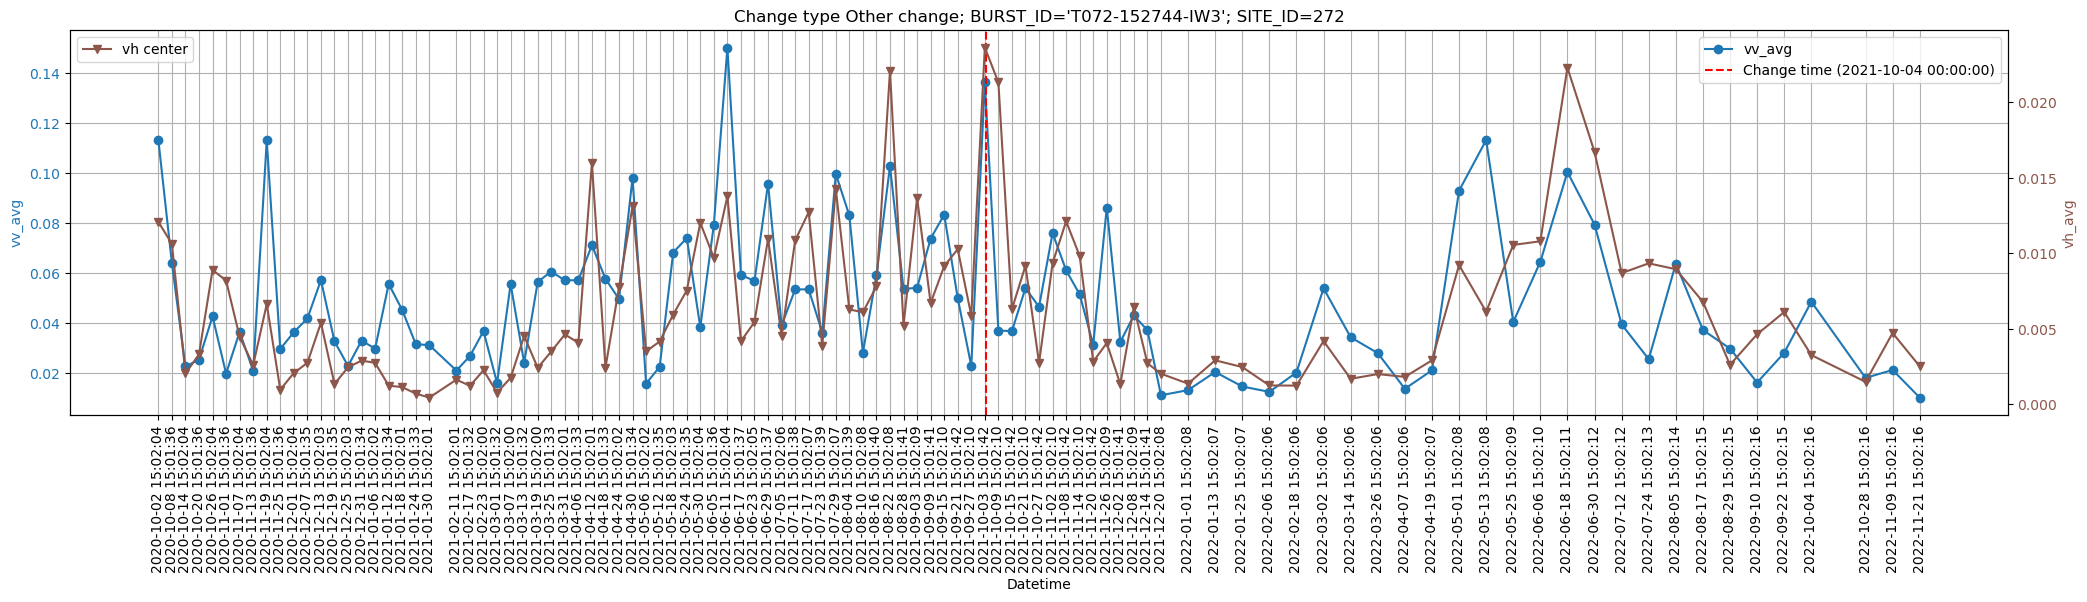

In [17]:
fig, ax1 = plt.subplots(figsize=(25, 5))
ax1.plot(df_rtc_ts['acq_datetime'], vv_c, marker='o', color='tab:blue', label='vv_avg')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('vv_avg', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df_rtc_ts['acq_datetime'], vh_c, marker='v', color='tab:brown', label='vh center')
ax2.set_ylabel('vh_avg', color='tab:brown')
ax2.tick_params(axis='y', labelcolor='tab:brown')
if POL_RATIO_PLOT:
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  
    ax3.plot(df_rtc_ts_wind['datetime'], df_rtc_ts_wind['vv/vh_avg'], marker='P', color='tab:purple', label='vv/vh_avg')
    ax3.set_ylabel('vv/vh_avg', color='tab:purple')
    ax3.tick_params(axis='y', labelcolor='tab:purple')

change_type = df_site.change_type.iloc[0]
plt.title(f'Change type {change_type}; {BURST_ID=}; {SITE_ID=}')
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    ax1.set_xticks(df_rtc_ts['acq_datetime'].tolist())
    ax1.set_xticklabels(df_rtc_ts['acq_datetime'].tolist(), rotation=90)

ax1.grid(True)

last_observed_time = df_site['last_observation_time'][0]

if not isinstance(last_observed_time, type(pd.NaT)):
    ax1.axvline(x=last_observed_time, color='b', linestyle='--', label=f'Last observation time ({last_observed_time})')
ax2.legend(loc='upper left')

change_time = df_site['change_time'][0]
ax1.axvline(x=change_time, color='r', linestyle='--', label=f'Change time ({change_time})')
ax1.legend()
plt.show()

- Change "accuracy" - take 1 - if first changed observation occurs after "last_observation_time" and within 1 acquisition after "change_time" then that is "perfect" accuracy.
- Change "accuracy" - take 2 - relaxed - if first changed observation occurs after last observation time or within a set time frame that is user defined.


In [18]:
# df_site.drop(columns=['change_time', 'last_observation_time']).explore(categorical=True, column='change_type', legend=True, marker_kwds={'radius':10})

# Mahalanobis 1d Distance Running

In [19]:
from distmetrics import compute_mahalonobis_dist_2d, compute_mahalonobis_dist_1d
import numpy as np
from tqdm import tqdm

In [20]:
def window_mahalanobis_1d_running(window_data: list[np.ndarray], n_pre_img: int = 5):
    N = len(window_data)
    dists = [compute_mahalonobis_dist_1d(window_data[k- n_pre_img : k ], window_data[k]) if k > n_pre_img else None for k in tqdm(range(N))]
    return dists
dist_objs = window_mahalanobis_1d_running(vv_arrs)
dist_vals = [d_obj.dist[1, 1] if d_obj is not None else np.nan for d_obj in dist_objs]
dist_dts = [df_rtc_ts['acq_datetime'].tolist()[k] for (k, d_obj) in enumerate(dist_objs) if d_obj is not None]
dist_plot = [dist_obj.dist[1, 1] for dist_obj in dist_objs if dist_obj is not None]

100%|█| 101/101 [00:00<00:00, 5443


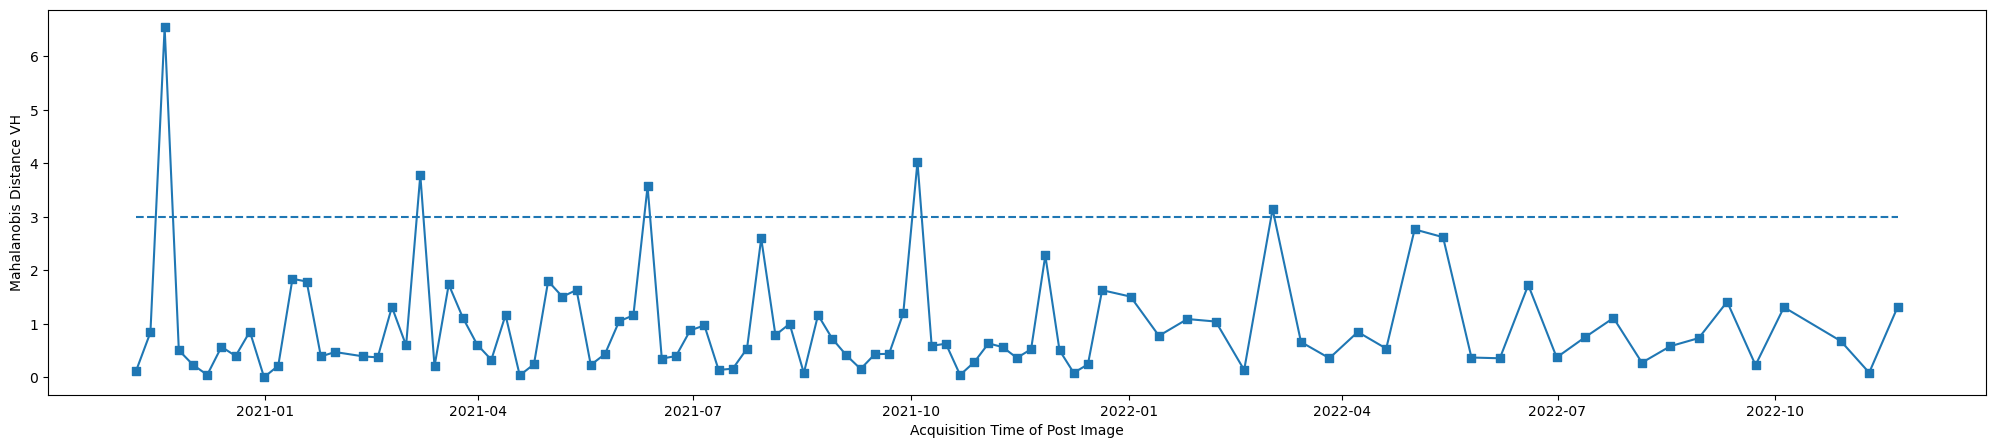

In [21]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.scatter(dist_dts, dist_plot, marker='s')
ax.plot(dist_dts, dist_plot)
ax.set_xlabel('Acquisition Time of Post Image')
ax.set_ylabel('Mahalanobis Distance VH')
ax.hlines(3, dist_dts[0], dist_dts[-1], ls='--')

# Example Workflow

In [22]:
def generate_post_idxs_for_workflow(acq_dt_l: list[pd.Timestamp],
                                    n_pre_img: int, 
                                    n_post_imgs_to_confirm: int,
                                    lookback_length_days: int) -> list:
    n_acqs = len(acq_dt_l)
    if lookback_length_days >= 60:
        temporal_window_size = n_pre_img // 2 + 1
        valid_post_idxs = [i for i, ts in enumerate(acq_dt_l) if (ts >= acq_dt_l[temporal_window_size] + pd.Timedelta(lookback_length_days, 'd')) and
                          (i > n_pre_img) and (i < n_acqs - n_post_imgs_to_confirm + 1)
                         ]
    elif lookback_length_days == 0:
         valid_post_idxs = list(range(n_pre_img + 1, n_acqs)) 
    else:
        raise ValueError('if lookback_length_days is nonzero, must be greater than 60')
    return valid_post_idxs


def lookup_pre_idx(post_idx: int,
                   acq_dt_l: list[pd.Timestamp],
                   n_pre_img: int,
                   lookback_length_days: int):
    if lookback_length_days >= 60:
        window_size = n_pre_img // 2
        valid_pre_idx = [i for (i, ts) in enumerate(acq_dt_l) if ts < (acq_dt_l[post_idx] - pd.Timedelta(lookback_length_days, 'd'))]
        if valid_pre_idx:
            pre_idx_center = valid_pre_idx[-1]
            pre_idxs = list(range(pre_idx_center - window_size, pre_idx_center + window_size + 1))
        else:
            raise ValueError('post idx does nothave valid pre-indices')
    elif lookback_length == 0:
         pre_idxs = list(range(post_idx - n_pre_img - 1, post_idx))
    else:
        raise ValueError('if lookback_length_days is nonzero, must be greater than 60')
    return pre_idxs

In [23]:
acq_dt_l = df_rtc_ts.acq_datetime.tolist()
n_pre_img = 5
n_post_imgs_to_confirm = 3
lookback_length_days = 365

In [24]:
valid_post_idxs = generate_post_idxs_for_workflow(acq_dt_l, 
                                                  n_pre_img, 
                                                  n_post_imgs_to_confirm, 
                                                  lookback_length_days)
valid_pre_idxs = [lookup_pre_idx(post_idx, acq_dt_l, n_pre_img, lookback_length_days) for post_idx in valid_post_idxs]

In [25]:
T = 3

def window_mahalanobis_1d_workflow(arr_data_l: list[list], 
                                   acq_dt_l: list[pd.Timestamp],
                                   n_pre_img: int = LOOKBACK_WINDOW, 
                                   n_post_imgs_to_confirm: int = 3,
                                   lookback_length_days: int = LOOKBACK_LENGTH_DAYS
                                   ):
    N = len(arr_data_l)
    M = len(acq_dt_l)
    if N != M:
        raise ValueError('arr_data_l and acq_dt_l must have same length')

    if (lookback_length_days != 0) and (lookback_length_days < 60):
        raise ValueError('If using non-zero lookback_length, must be larger than 60 days')
    valid_post_idxs = generate_post_idxs_for_workflow(acq_dt_l, n_pre_img, n_post_imgs_to_confirm, lookback_length_days)
    valid_pre_idxs = [lookup_pre_idx(post_idx, acq_dt_l, n_pre_img, lookback_length_days) for post_idx in valid_post_idxs]
    
    dist_objs = [compute_mahalonobis_dist_1d(arr_data_l[pre_idxs[0]: pre_idxs[-1]], 
                                             [arr_data_l[post_idx + j] for j in range(n_post_imgs_to_confirm)],
                                             window_size=3) for (pre_idxs, post_idx) in zip(valid_pre_idxs, valid_post_idxs)]
    # 1 for change and 0 elsewhere
    # note the [1, 1] indexing!
    change_pts_init = [int(all([d[1, 1] > T for d in dist_ob.dist])) if dist_ob is not None else 0 for dist_ob in dist_objs]
    # Change
    try:
        ind_c = change_pts_init.index(1)
        change_pts = [int(ind >= ind_c) for ind in range(len(change_pts_init))]
    # No Change
    except ValueError:
        change_pts = change_pts_init
    valid_dts = pd.Series([acq_dt_l[k] for k in valid_post_idxs])
    return valid_dts, np.array(change_pts)

In [26]:
ts_obs, y_obs = window_mahalanobis_1d_workflow(vh_arrs, df_rtc_ts.acq_datetime.tolist())

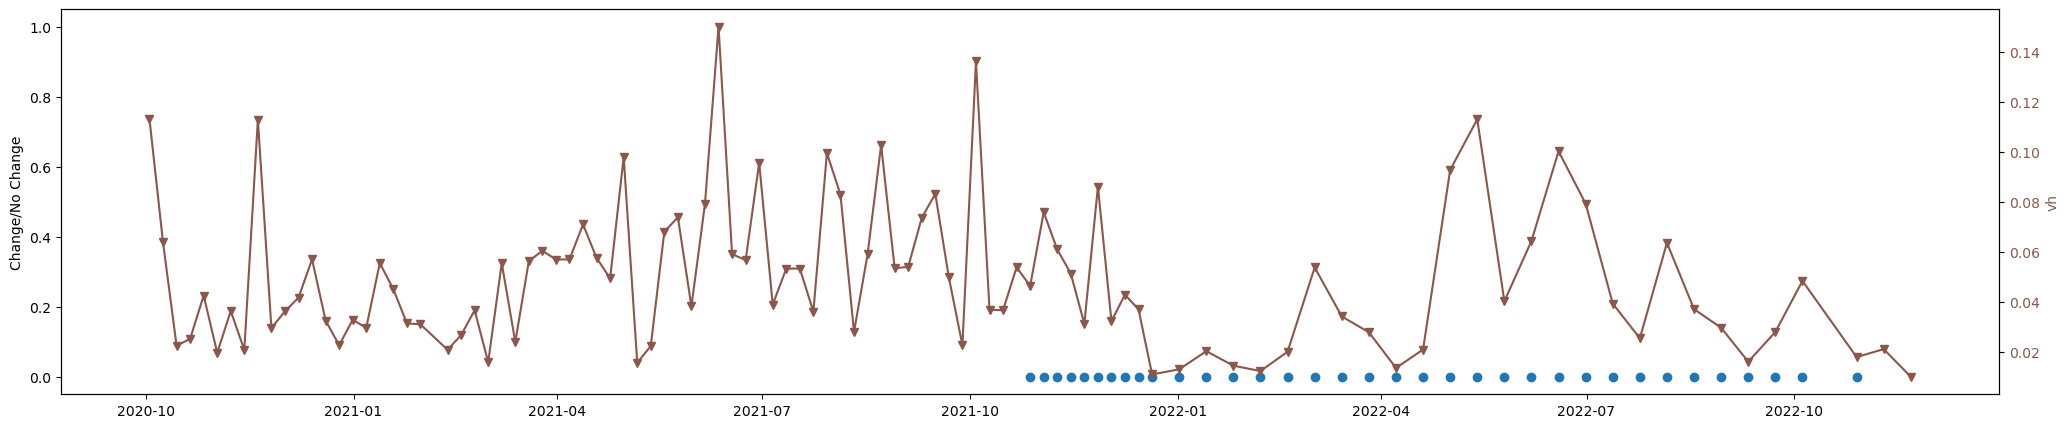

In [27]:
fig, ax1 = plt.subplots(figsize=(25, 5))


ax1.scatter(ts_obs, y_obs)
ax1.set_ylabel('Change/No Change')
ax1.set_ylim(-.05, 1.05)
ax2 = ax1.twinx()
bs = vv_c#.rolling(3).sum()
ax2.plot(df_rtc_ts['acq_datetime'], bs, 
         marker='v', color='tab:brown', label='vh_avg')
ax2.set_ylabel('vh', color='tab:brown')
ax2.tick_params(axis='y', labelcolor='tab:brown')

# Accuracy

Let's just compare data directly and get accuracy per site.

In [28]:
change_time = df_site['change_time'][0]
last_observation_time = df_site['last_observation_time'][0]

FIRST_OBSERVATION_VAL_DATA = pd.Timestamp('2021-10-01')
NODATA_VAL = 3

def generate_val_vec(valid_obs: pd.Series,
                     last_observed: pd.Timestamp, 
                     change_time: pd.Timestamp, 
                            ) -> np.ndarray:
    """
    0 = no change
    1 = change
    2 = either change / no change
    255 = nodata
    """
    y_val = np.zeros(valid_obs.shape[0], dtype=np.uint8)
    y_val[valid_obs < FIRST_OBSERVATION_VAL_DATA] = NODATA_VAL
    
    # No change
    if isinstance(change_time, type(pd.NaT)):
        pass
    # Change
    else:
        # after change time - these are definite change observations
        y_val[(valid_obs >= change_time)] = 1
        # between change time and last observations - these are indeterminate
        if isinstance(last_observed_time, type(pd.NaT)):
            y_val[valid_obs < change_time] = 2
        else:
            ind = (valid_obs < change_time) & (valid_obs > last_observed_time)
            y_val[ind] = 2
    return y_val

def get_total_accuracy(y_val, y_obs) -> float:
    mask = y_val == 255

    acc = ((y_val == 2) | (y_val == y_obs)).sum() / (~mask).sum()
    return acc

def get_user_change_accuracy(y_val, y_obs) -> float:
    mask = y_val == 255
    y_val_is_1 = (y_val == 1)
    
    if y_val_is_1.sum() == 0:
        user_acc = np.nan
    else:
        user_acc = (y_val_is_1 & (y_obs == 1)).sum() / (y_val_is_1 & (y_val != 2) & ~mask).sum()
    return user_acc


def get_producer_change_accuracy(y_val, y_obs) -> float:
    mask = (y_val == 255)
    y_obs_is_1 = (y_obs == 1)
    
    if y_obs_is_1.sum() == 0:
        prod_acc = np.nan
    else:
        prod_acc = (y_obs_is_1 & (y_val == 1)).sum() / (y_obs_is_1 & (y_val != 2) & ~mask).sum()
    return prod_acc

In [29]:
y_val = generate_val_vec(ts_obs, last_observation_time, change_time)
prod_acc = get_producer_change_accuracy(y_val, y_obs)
user_acc = get_user_change_accuracy(y_val, y_obs)
total_acc = get_total_accuracy(y_val, y_obs)

print(f'{total_acc=} {user_acc=} {prod_acc=}')

total_acc=0.0 user_acc=0.0 prod_acc=nan


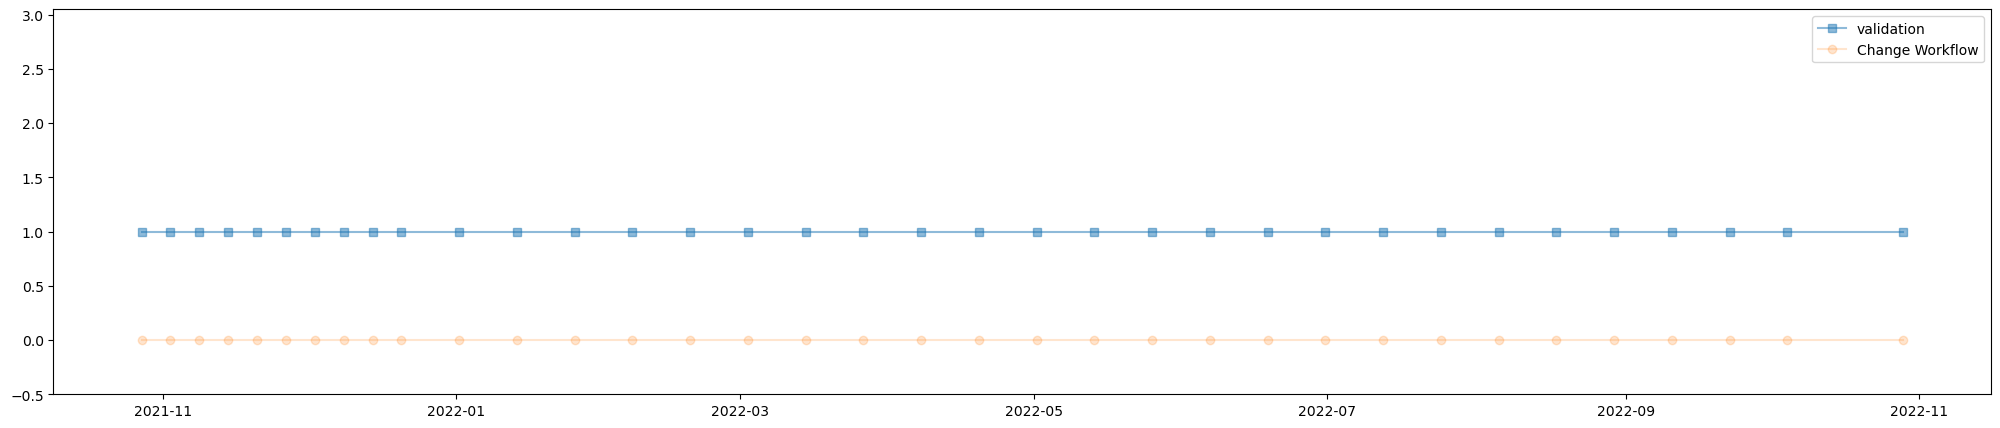

In [30]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(ts_obs, y_val, marker='s', label='validation', alpha=.5)
ax.plot(ts_obs, y_obs, marker='o', label='Change Workflow', alpha=.2)
ax.set_ylim(-0.5, 3.05)
plt.legend()

# Serialize

In [31]:
df_data = df_site.iloc[:1].copy()
df_data.loc[:, 'jpl_burst_id'] = BURST_ID
df_data['accuracy'] = total_acc
df_data['user_accuracy'] = user_acc
df_data['prod_accuracy'] = prod_acc
df_data

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry,accuracy,user_accuracy,prod_accuracy
0,272,VLmaj,Other change,2021-10-04,NaT,38TML,T072-152744-IW3,POINT (44.21285 41.32529),0.0,0.0,NaN


In [32]:
out_dir = Path(f'site_metrics/lookback-{str(LOOKBACK_LENGTH_DAYS)}-days__window-{LOOKBACK_WINDOW}')
out_dir.mkdir(exist_ok=True, parents=True)
out_dir

PosixPath('site_metrics/lookback-365-days__window-6')

In [33]:
df_data.to_parquet(out_dir / f'{SITE_ID}__{BURST_ID}.parquet')